# Auto encoder

## Read data

In [1]:
from prepare_data import listTurbines


turbines = listTurbines()
turbines

['CRKALN_001',
 'CRKALN_002',
 'CRKALN_003',
 'CRKALN_004',
 'CRKALN_005',
 'CRKALN_006',
 'CRKALN_007',
 'CRKALN_008',
 'CRKALN_009',
 'CRKALN_010']

In [2]:
from prepare_data import TurbineData


turbineData = TurbineData(turbines[1], verbose=False)
print(turbineData.data3d.shape)
print(turbineData.columns)

(99264, 96, 28)
Index(['datetime', 'avgwindspeed', 'avgpower', 'windspeedstandarddeviation',
       'nacelleposition', 'avgwinddirection', 'availablepowerpublished',
       'avgrotorspeed', 'avgpitchangle', 'avgreactivepower',
       'ambienttemperature', 'avghumidity', 'turbinepressure', 'density',
       'latitude', 'longitude', 'cutoutwindspeed', 'ratedwindspeed',
       'rotordiameter', 'hubheight', 'groundlevelaltitude', 'turbulent',
       'underperformanceprobability', 'overperformanceprobability',
       'turbulentvalid', 'underperformanceprobabilityvalid',
       'overperformanceprobabilityvalid', 'original_feature_count'],
      dtype='object')


### Filter valid data

In [3]:
idPower = turbineData.getIdOfColumn("avgpower")
idWind = turbineData.getIdOfColumn("avgwindspeed")

idPower, idWind

(2, 1)

In [4]:
turbineData.verbose = True
normalIndices = turbineData.getNormalIndices(
    maxConsecutiveInvalid=0,  # 1 hours of consecutive invalid data
    maxInvalidRate=0.5,
    underperformThreshold=1,  # ignore underperf threshold
)

Valid: 8946
Not underperform: 99264
Normal: 8946


## Split train test

In [5]:
import numpy as np


SEED = 17
TEST_RATIO = 0.2
VAL_RATIO = 0.2


# suffle data
np.random.seed(SEED)
np.random.shuffle(normalIndices)

# split data
n_test = int(len(normalIndices) * TEST_RATIO)
testIndices = normalIndices[:n_test]
trainIndices = normalIndices[n_test:]

n_val = int(len(trainIndices) * VAL_RATIO)
valIndices = trainIndices[:n_val]
trainIndices = trainIndices[n_val:]

print(f"Train: {len(trainIndices)} Val: {len(valIndices)} Test: {len(testIndices)}")

Train: 5726 Val: 1431 Test: 1789


In [6]:
from sklearn.discriminant_analysis import StandardScaler

from cls_dataset import toTurbineDatasets


targetFeats = [
    "ambienttemperature",
]
immuteFeats = [
    "datetime"
]
featsInDataSet = targetFeats + immuteFeats


# train the transformer
stdScaler = StandardScaler()

# h5py requires sorted indices
sortedTrainIndices = trainIndices.copy()
sortedTrainIndices.sort()  

trainData2d = turbineData.data3d[sortedTrainIndices, 0, :]
targetFeatIndices = [turbineData.getIdOfColumn(feat) for feat in targetFeats]
transformerTrainData = trainData2d[:, targetFeatIndices]
print(f"Train data for scaler and imputer {transformerTrainData.shape}")

transformerTrainData = stdScaler.fit_transform(transformerTrainData)

trainSet, valSet, testSet = toTurbineDatasets(
    turbineData,
    (trainIndices, valIndices, testIndices), # type: ignore
    targetFeats,
    stdScaler.transform,
    immuteFeats,
)

trainSet.save("tmp/trainSet")
valSet.save("tmp/valSet")
testSet.save("tmp/testSet")


# from cls_dataset import TurbineDataset


# trainSet = TurbineDataset.load("tmp/trainSet")
# valSet = TurbineDataset.load("tmp/valSet")
# testSet = TurbineDataset.load("tmp/testSet")

# with open("./train.log", "w") as f:
#     print(trainSet[0][0], file=f)

print(f"Data shape: {trainSet[0][0].shape}")

Train data for scaler and imputer (5726, 1)
Data shape: (2,)


## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from model_options.model_simple_singular import SimpleDecoder, SimpleEncoder


class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = SimpleEncoder(latent_dim)
        self.decoder = SimpleDecoder(reconstructDim=96)
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


# test if the model is working
testModel = Autoencoder(1024)

# pass a random tensor to the model
x = torch.randn(32, 1, 96)
output = testModel(x)

print(f"Expected output shape: {x.shape}")
print(f"Output shape: {output.shape}")

# print(x[0])
# print(output[0])

del testModel
del x
del output

Expected output shape: torch.Size([32, 1, 96])
Output shape: torch.Size([32, 1, 96])


## Training 

In [21]:
def infer(model, device, testLoader):
    """_summary_

    Args:
        model (_type_): _description_
        device (_type_): _description_
        testLoader (_type_): _description_

    Returns:
        _type_: pred, actual, predWithTime, actualWithTime
    """
    
    
    model.eval()
    predProba = []
    actual = []
    outputsWithTime = []
    actualWithTime = []

    with torch.no_grad():
        for x in testLoader:
            x = x.to(device)
            
            timeStamp = x[:, :, -1]
            inp = x[:, :, 0:-1]

            # reshape to (batch, feats as channels, timesteps)
            inp = inp.permute(0, 2, 1)
            outputs = model(inp)

            actual.append(inp)
            predProba.append(outputs)
            
            timeStamp = timeStamp.to(device)
            outputWithTime = torch.cat([outputs.permute(0, 2, 1), timeStamp.unsqueeze(2)], dim=2)
            outputsWithTime.append(outputWithTime)
            actualWithTime.append(x)


    return torch.cat(predProba), torch.cat(actual), torch.cat(outputsWithTime), torch.cat(actualWithTime)

In [ ]:
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    n_epochs=100,
    earlyStopping=10,
):
    optimScheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.2)

    # Training loop
    earlyStopping = 10
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(n_epochs):
        trainLoss = 0
        trainDiff = 0
        model.train()

        for batch_idx, x in enumerate(trainLoader):
            # remove the last feature (timestamp)
            x = x[:, :, 0:-1]

            x = x.float().to(device)
            # reshape to (batch, feats as channels, timesteps)
            x = x.permute(0, 2, 1)

            optimizer.zero_grad()

            # Forward pass
            reconstructs = model(x)

            # match reconstructed shape with inputs
            n_timestepsReconstructed = reconstructs.shape[-2]
            x = x[:, :n_timestepsReconstructed, :]

            loss = criterion(reconstructs, x)
            diff = torch.abs(reconstructs - x).mean()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            trainLoss += loss.item()
            trainDiff += diff.item()

            # Print every 100 batches
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(trainLoader)}], Loss: {loss.item():.4f}, Diff: {diff.item():.4f}"
                )

        trainLoss /= len(trainLoader)
        trainDiff /= len(trainLoader)
        trainLosses.append(trainLoss)

        # Validation loss
        pred, actual, *_ = infer(model, device, valLoader)
        valLoss = criterion(pred, actual)
        valDiff = torch.abs(pred - actual).mean()

        valLosses.append(valLoss.detach().cpu().numpy())

        print(
            f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}, Train Diff: {trainDiff:.4f}, Val Diff: {valDiff:.4f}"
        )
        print("=" * 50)

        # Early stopping
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience > earlyStopping:
                break

        optimScheduler.step(valLoss)

    # reload the model
    model.load_state_dict(bestModelState)  # type: ignore
    
    return model, trainLosses, valLosses

In [ ]:

from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True, pin_memory=True)
valLoader = DataLoader(valSet, batch_size=64, shuffle=False, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False, pin_memory=True)

model = Autoencoder(516).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimScheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.2)

# Training loop
num_epochs = 500
earlyStopping = 10

trainLosses = []
valLosses = []

model, trainLosses, valLosses = train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    n_epochs=num_epochs,
    earlyStopping=earlyStopping,
)

Device: cuda
Epoch [1/500], Step [0/90], Loss: 1.1363, Diff: 0.8665
Epoch [1/500], Train Loss: 103701.6276, Val Loss: 36.0292, Train Diff: 117.9803, Val Diff: 4.9584
Epoch [2/500], Step [0/90], Loss: 36.8286, Diff: 4.9413
Epoch [2/500], Train Loss: 4.3922, Val Loss: 1.3187, Train Diff: 1.3443, Val Diff: 0.8017
Epoch [3/500], Step [0/90], Loss: 1.5633, Diff: 0.8588
Epoch [3/500], Train Loss: 1.0493, Val Loss: 0.8495, Train Diff: 0.7030, Val Diff: 0.6400
Epoch [4/500], Step [0/90], Loss: 0.7020, Diff: 0.5956
Epoch [4/500], Train Loss: 0.7094, Val Loss: 0.5963, Train Diff: 0.5831, Val Diff: 0.5417
Epoch [5/500], Step [0/90], Loss: 0.5447, Diff: 0.5234
Epoch [5/500], Train Loss: 0.5331, Val Loss: 0.4624, Train Diff: 0.5111, Val Diff: 0.4838
Epoch [6/500], Step [0/90], Loss: 0.4803, Diff: 0.4994
Epoch [6/500], Train Loss: 0.4236, Val Loss: 0.3814, Train Diff: 0.4630, Val Diff: 0.4450
Epoch [7/500], Step [0/90], Loss: 0.3068, Diff: 0.4021
Epoch [7/500], Train Loss: 0.3563, Val Loss: 0.3251, 

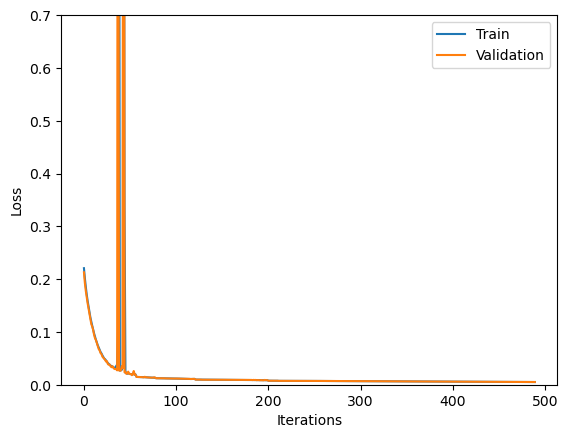

In [16]:
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.plot(trainLosses[10:])
plt.plot(valLosses[10:])

plt.ylim(-0, 0.7)

plt.legend(["Train", "Validation"])
plt.show()

## Evaluating

In [22]:
tempIn = []
tempOut = []

rotIn = []
rotOut = []

dateIn = []

testLoss = 0

model.eval()
_, _, outputs, actual = infer(model, device, testLoader)
testLoss = criterion(outputs, actual).item()
print(f"Test loss: {testLoss}")

Test loss: 0.0025519090704619884


In [25]:
outputs.size()

torch.Size([1789, 96, 2])

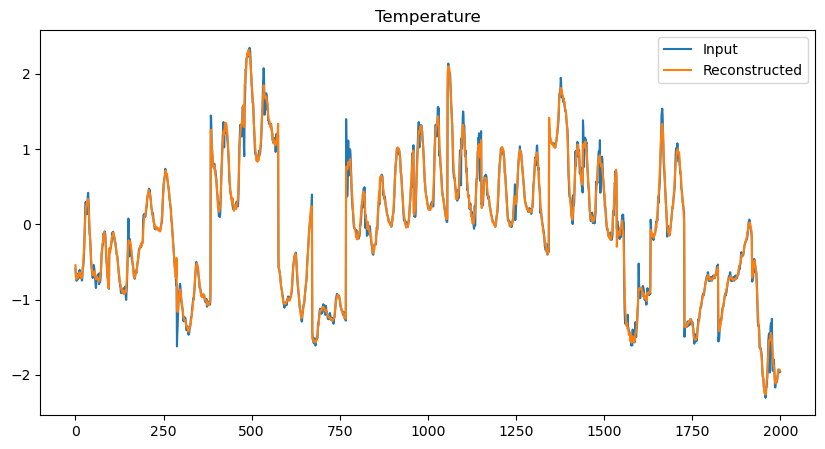

In [32]:
a = 0
b = a + 2000

tempIn = actual[a:b, :, 0].detach().cpu().numpy().reshape(-1)
tempOut = outputs[a:b, :, 0].detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(10, 5))
plt.plot(tempIn[a:b], label="Input")
plt.plot(tempOut[a:b], label="Reconstructed")
plt.legend()
plt.title("Temperature")
plt.show()

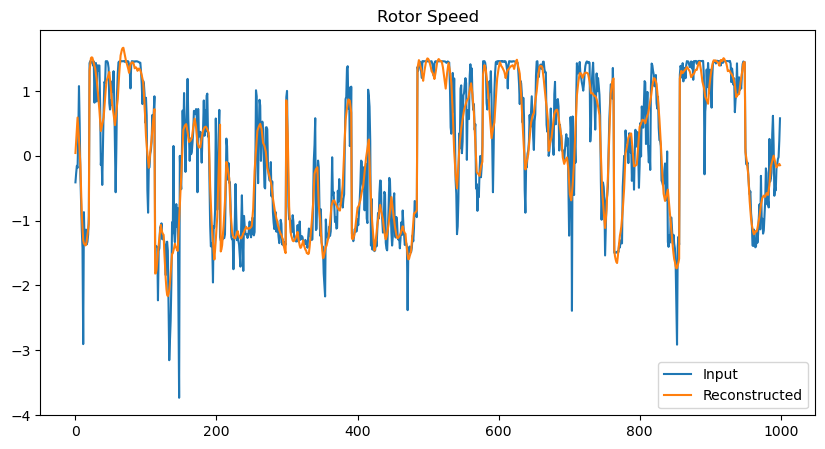

In [ ]:
a = 3700
b = a + 1000

plt.figure(figsize=(10, 5))
plt.plot(rotIn[a:b], label="Input")
plt.plot(rotOut[a:b], label="Reconstructed")
plt.title("Rotor Speed")
plt.legend()
plt.show()

In [ ]:
sortedTempIn, sortedTempOut = zip(*sorted(zip(tempIn, tempOut)))
sortedRotIn, sortedRotOut = zip(*sorted(zip(rotIn, rotOut)))

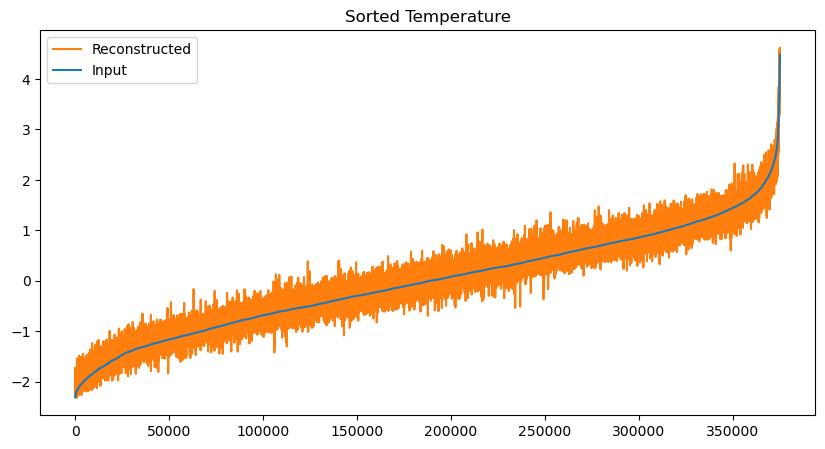

In [ ]:
a = 0
b = len(tempIn)

plt.figure(figsize=(10, 5))
plt.plot(sortedTempOut[a:b], label="Reconstructed", color="#ff7f0e")
plt.plot(sortedTempIn[a:b], label="Input", color="#1f77b4")
plt.title("Sorted Temperature")
plt.legend()
plt.show()

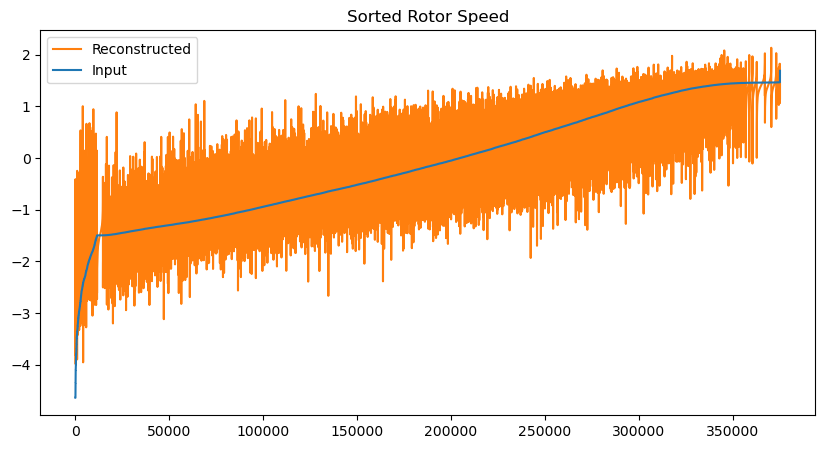

In [ ]:
a = 0
b = len(tempIn)

plt.figure(figsize=(10, 5))
plt.plot(sortedRotOut[a:b], label="Reconstructed", color="#ff7f0e")
plt.plot(sortedRotIn[a:b], label="Input", color="#1f77b4")
plt.title("Sorted Rotor Speed")
plt.legend()
plt.show()

# [scatter] Real vs. predicted

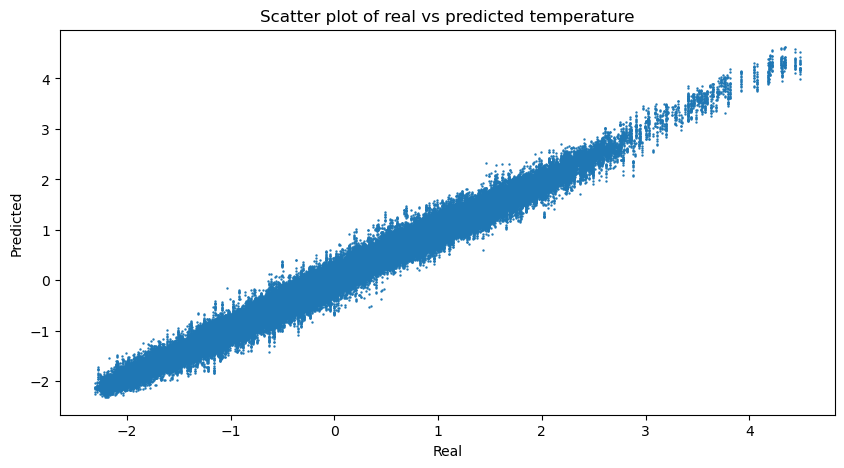

In [ ]:
# scratter plot of real vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(tempIn, tempOut, s=0.5)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Scatter plot of real vs predicted temperature")
plt.show()

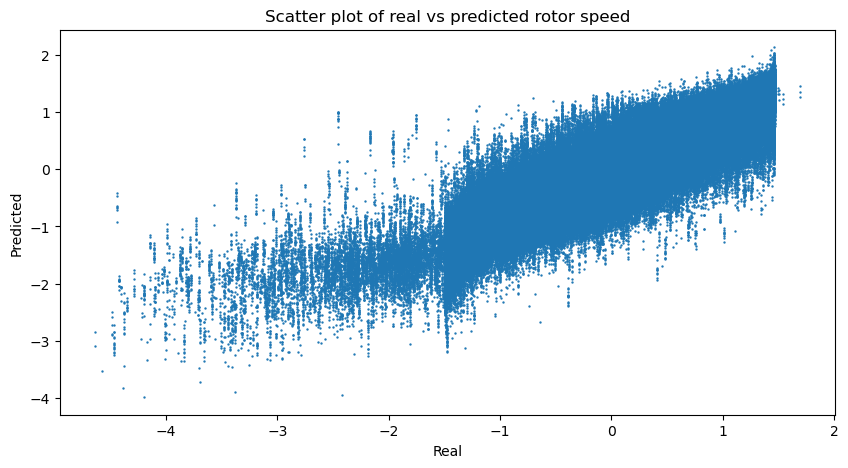

In [ ]:
# scratter plot of real vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(rotIn, rotOut, s=0.5)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Scatter plot of real vs predicted rotor speed")
plt.show()

# [line] Error (either MAE or MSE) through time (aggregate weekly or monthly to ease visualization)

# [scatter] Error vs. underperformance probability

In [ ]:
turbineData.close()